In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from karateclub.graph_embedding import Graph2Vec

In [2]:
CAUSAL_COEFF_STRENGTH = 1.5

# Load EC networks into a netwokx dataset

In [3]:
networks_dir = "../Datasets/SynapseSnap/effective-connectivity-networks"

# List of all networks
np_files = os.listdir(networks_dir)

# Get labels from file names
labels = np.array([np_file[4:7] == 'PAT' for np_file in np_files])

# Load all networks, and calculate mean score and std
np_networks = [np.load(os.path.join(networks_dir, np_file))[1] for np_file in np_files]
score_mean, score_std = np.array(np_networks).mean(), np.array(np_networks).std()

# Binarize networks
np_networks = np_networks > score_mean + CAUSAL_COEFF_STRENGTH * score_std

# Convert to networkx graphs
dataset = [nx.from_numpy_array(np_network, create_using=nx.DiGraph) for np_network in np_networks]

## Plot a few samples

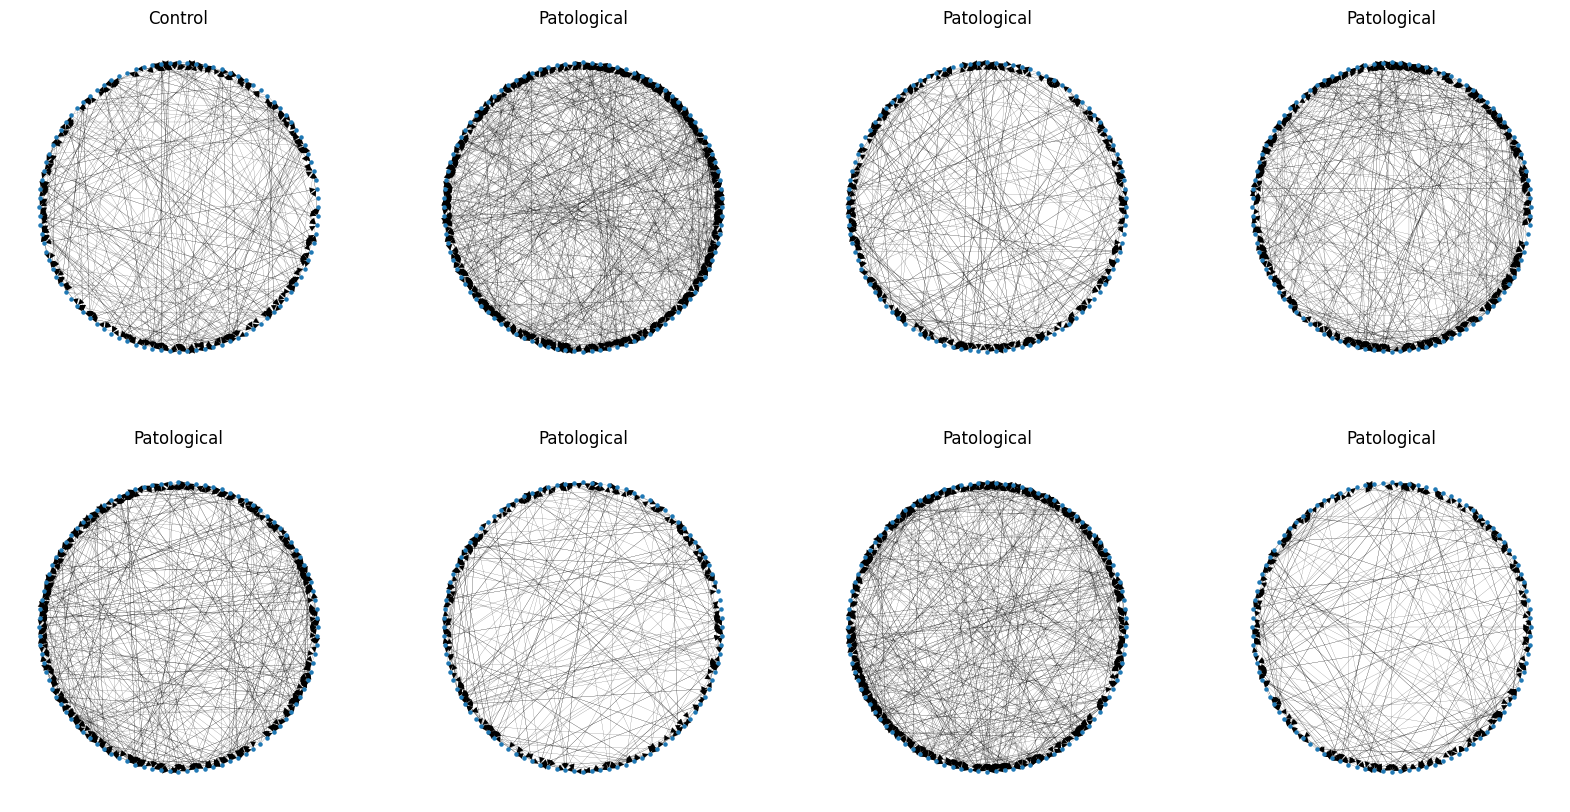

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
indices = np.random.choice(len(dataset), size=8, replace=False)

for i, ax in zip(indices, axes.flatten()):
    net = dataset[i]
    nx.draw(net, ax=ax, pos=nx.circular_layout(net), node_size=5, width=0.1, with_labels=False)
    ax.set_title("Patological" if labels[i] else "Control")

# Embedd using graph2vec

In [5]:
model = Graph2Vec(dimensions=2)
model.fit(dataset)
embeddings = model.get_embedding()

## Plot embeddings

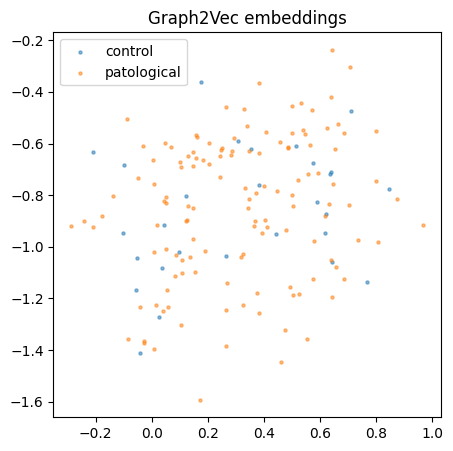

In [6]:
# plot the embeddings and label them
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(embeddings[labels == 0, 0], embeddings[labels == 0, 1], c='tab:blue', s=5, alpha=0.5, label='control')
ax.scatter(embeddings[labels == 1, 0], embeddings[labels == 1, 1], c='tab:orange', s=5, alpha=0.5, label='patological')
ax.set_title('Graph2Vec embeddings')
plt.legend()
plt.show()